# Machine Learning Pipeline Design and Implementation Plan

## 1. Pipeline Overview

The goal of this pipeline is to predict the loan status based on various features of loan applications. The pipeline is designed to be modular, scalable, and adaptable for continuous improvement. It consists of eight key steps:

1. **Data Ingestion**
2. **Data Preprocessing**
3. **Feature Engineering**
4. **Hyperparameter Tuning**
5. **Model Training & Validation**
6. **Model Evaluation**
7. **Model Selection & Deployment**
8. **Continuous Monitoring & Retraining**

## 2. Pipeline Diagram

![Pipeline Diagram](Pipeline_Diagram.png)

## 3. Detailed Pipeline Plan

### Step 1: Data Ingestion

**Description:**
- Load data from `loan.csv`.
- Handle missing values and inconsistencies early on.

**Implementation:**
- Use Python’s `pandas` to load data and validate it for any missing values or data type issues.

**Considerations:**
- Data integrity and consistency must be ensured at this step.
- Automate data ingestion to handle updates.

### Step 2: Data Preprocessing

**Description:**
- Clean, transform, and encode the raw data into a format that can be used by the model.
- Handle missing values, encode categorical variables, and scale numerical features.

**Implementation:**
- Implement using scikit-learn’s `Pipeline` feature for modular and reproducible preprocessing.

**Considerations:**
- Ensure transformations are applied consistently across training and test data to prevent data leakage.

### Step 3: Feature Engineering

**Description:**
- Create new features from existing data to improve model performance.

**Implementation:**
- Generate custom features relevant to the problem, like `loan_to_payment_ratio`.

**Considerations:**
- Features should be relevant and add predictive value.
- Automate to maintain consistency.

### Step 4: Hyperparameter Tuning

**Description:**
- Optimize model hyperparameters using techniques like Bayesian optimization with Optuna.

**Implementation:**
- Perform stratified K-Fold cross-validation with SMOTE for class imbalance handling.

**Considerations:**
- Validate on multiple metrics to ensure robustness.
- Avoid overfitting during hyperparameter search.

### Step 5: Model Training & Validation

**Description:**
- Train the model using the best hyperparameters and validate using cross-validation.

**Implementation:**
- Train the model using LightGBM and validate on a separate validation set.

**Considerations:**
- Regularization and early stopping should be applied to avoid overfitting.

### Step 6: Model Evaluation

**Description:**
- Evaluate the model using metrics like accuracy, AUC, precision, recall, F1-score, and log loss.

**Implementation:**
- Use scikit-learn’s metrics to assess performance and generate a classification report and confusion matrix.

**Considerations:**
- Consider class imbalance in the evaluation by focusing on metrics like recall and F1-score.

### Step 7: Model Selection & Deployment

**Description:**
- Select the best model based on evaluation metrics and deploy it. Save preprocessing objects (e.g., encoders, scalers) for future use.

**Implementation:**
- Save the model and preprocessing pipeline with `joblib`, deploy as an API using FastAPI.

**Considerations:**
- Ensure consistency between training and inference by saving the preprocessing pipeline.
- Secure and monitor the API.

### Step 8: Continuous Monitoring & Retraining

**Description:**
- Monitor model performance in production and retrain as necessary using new data.

**Implementation:**
- Set up logging and monitoring to track performance, and schedule retraining with new data.

**Considerations:**
- Automate monitoring and retraining to adapt to changes in data distribution.
- Ensure the model remains accurate and relevant.

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import skew, kurtosis

In [3]:
df = pd.read_csv('data/loan.csv', parse_dates=['applicationDate', 'originatedDate'])

# Overview of the dataset
print("Shape of the dataset:", df.shape)
print("Columns in the dataset:", df.columns.tolist())
print("First few rows of the dataset:")
display(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Shape of the dataset: (577682, 19)
Columns in the dataset: ['loanId', 'anon_ssn', 'payFrequency', 'apr', 'applicationDate', 'originated', 'originatedDate', 'nPaidOff', 'approved', 'isFunded', 'loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount', 'state', 'leadType', 'leadCost', 'fpStatus', 'clarityFraudId', 'hasCF']
First few rows of the dataset:


,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23 17:29:01.940,False,NaT,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01 13:51:14.709,False,NaT,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06 23:58:08.880,False,NaT,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05 22:31:34.304,False,NaT,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1


Missing values in each column:
loanId               256
payFrequency        1273
apr                 3922
originatedDate    531638
nPaidOff              24
loanStatus           391
loanAmount          2250
state                132
fpStatus          525959
clarityFraudId    219989
dtype: int64


<Figure size 720x432 with 0 Axes>

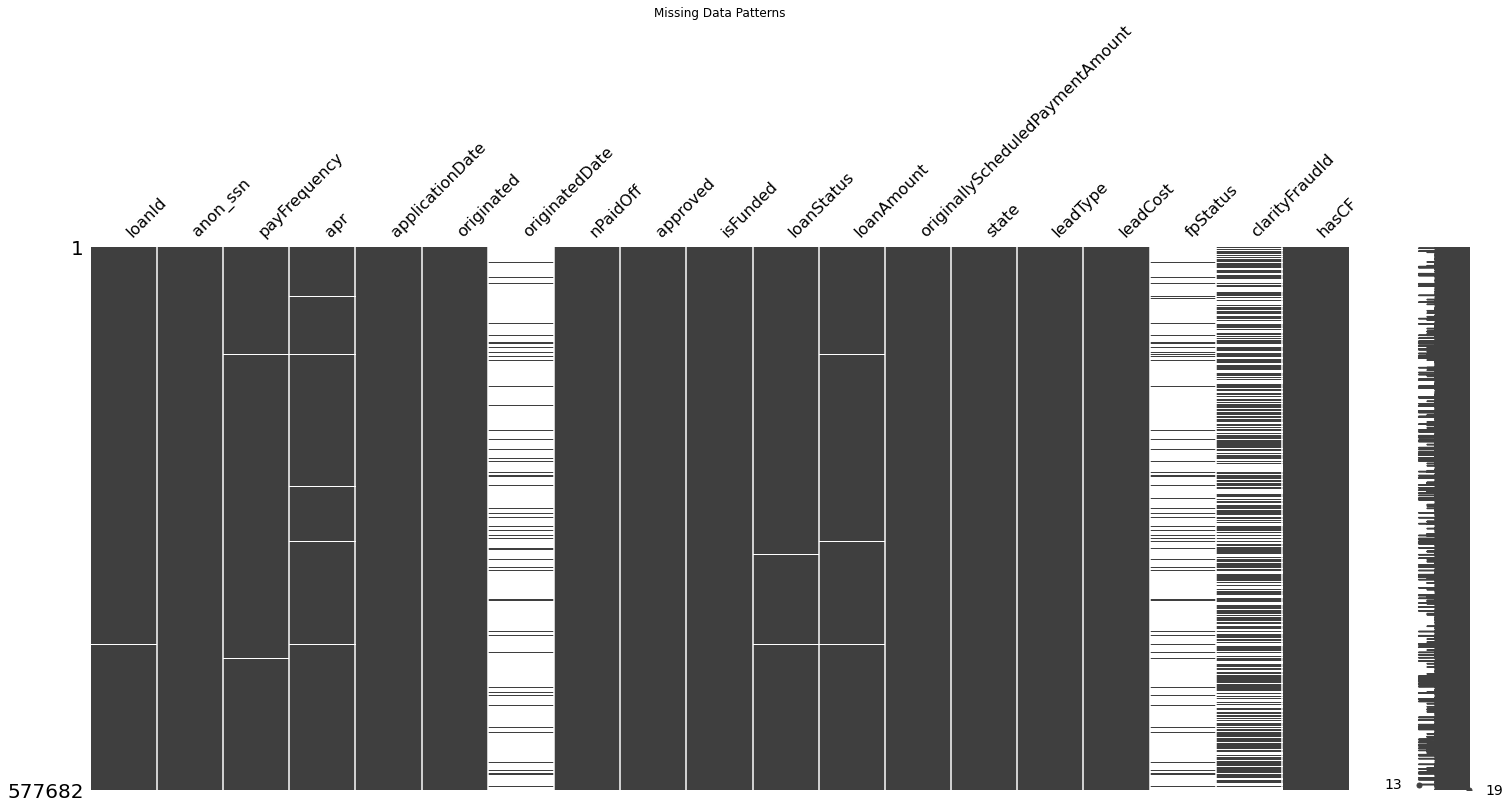

In [4]:
# Visualize missing data patterns
plt.figure(figsize=(10, 6))
msno.matrix(df)
plt.title("Missing Data Patterns")
plt.show()

<Figure size 720x432 with 0 Axes>

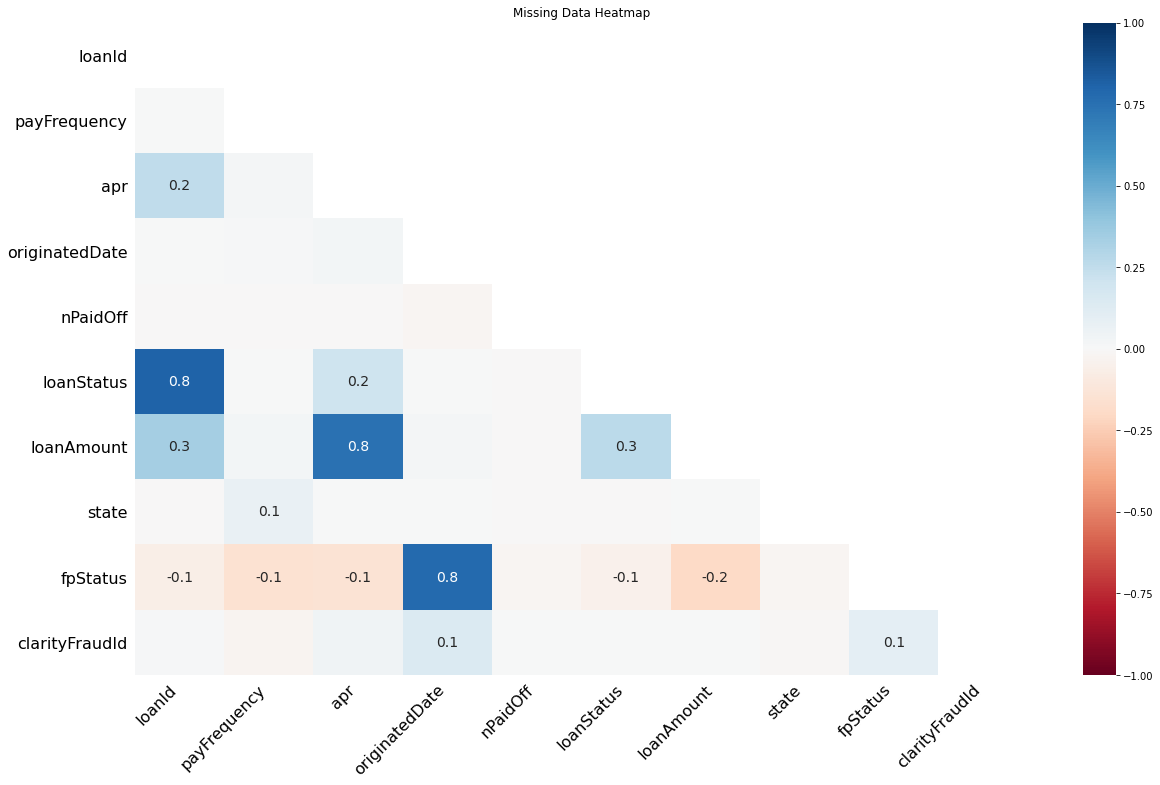

In [5]:
# Visualize missing data heatmap
plt.figure(figsize=(10, 6))
msno.heatmap(df)
plt.title("Missing Data Heatmap")
plt.show()

In [6]:
print("Summary statistics of numerical features:")
display(df.describe())

print("Summary statistics of categorical features:")
display(df.describe(include=[object]))

Summary statistics of numerical features:


,apr,nPaidOff,isFunded,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF
count,573760.000000,577658.000000,577682.000000,575432.000000,577682.000000,577682.000000,577682.000000
mean,553.080972,0.037887,0.067480,514.245084,1428.897209,7.854389,0.619187
std,110.046159,0.333366,0.250852,320.939929,925.009141,12.853451,0.485587
min,0.000000,0.000000,0.000000,0.000000,-816.710000,0.000000,0.000000
25%,490.000000,0.000000,0.000000,350.000000,1023.640000,3.000000,0.000000
50%,590.000000,0.000000,0.000000,500.000000,1245.250000,3.000000,1.000000
75%,601.000000,0.000000,0.000000,500.000000,1615.660000,6.000000,1.000000
max,705.590000,21.000000,1.000000,5000.000000,19963.630000,200.000000,1.000000


Summary statistics of categorical features:


,loanId,anon_ssn,payFrequency,loanStatus,state,leadType,fpStatus,clarityFraudId
count,577426,577682,576409,577291,577550,577682,51723,357693
unique,577426,459393,5,21,44,10,8,314915
top,LL-I-07399092,c8bb49de1f8ff99d2ecddfb7037dc66e,B,Withdrawn Application,OH,bvMandatory,Checked,561e95f7e4b0efa8a6cdc975
freq,1,35,316654,450984,90496,475001,32978,15


In [7]:
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
skewness = df[numerical_features].apply(lambda x: skew(x.dropna()))
kurtosis_vals = df[numerical_features].apply(lambda x: kurtosis(x.dropna()))

print("Skewness of numerical features:")
print(skewness)

print("Kurtosis of numerical features:")
print(kurtosis_vals)

Skewness of numerical features:
apr                                 -1.337617
nPaidOff                            19.180660
isFunded                             3.448414
loanAmount                           5.307545
originallyScheduledPaymentAmount     4.702808
leadCost                             5.986517
hasCF                               -0.490898
dtype: float64
Kurtosis of numerical features:
apr                                   1.417330
nPaidOff                            658.338827
isFunded                              9.891562
loanAmount                           36.832668
originallyScheduledPaymentAmount     34.834083
leadCost                             55.872749
hasCF                                -1.759020
dtype: float64


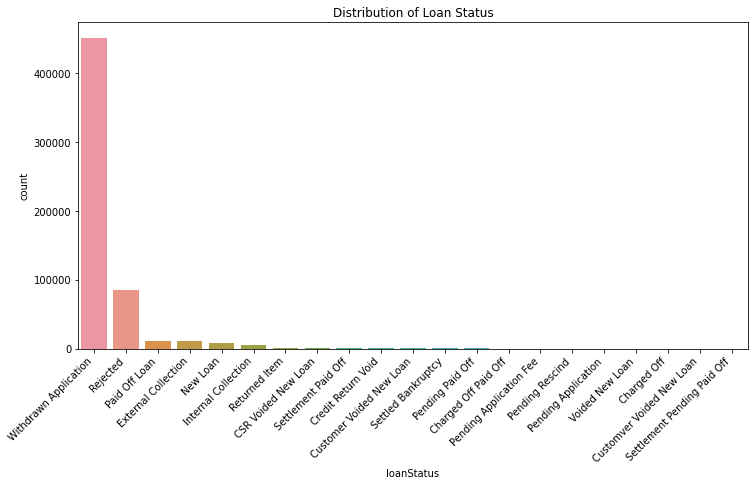

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='loanStatus', order=df['loanStatus'].value_counts().index)
plt.title('Distribution of Loan Status')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
categorical_features = df.select_dtypes(include=[object]).columns.tolist()
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.show()

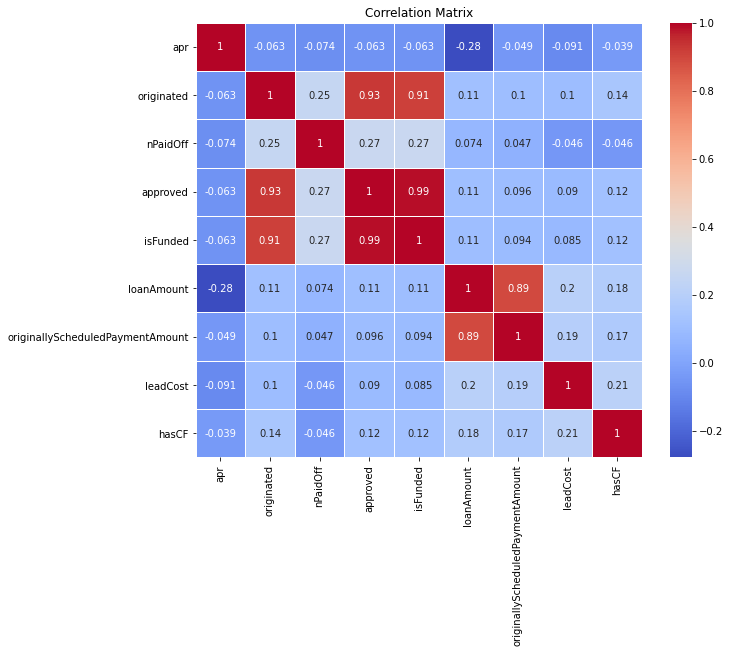

In [9]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

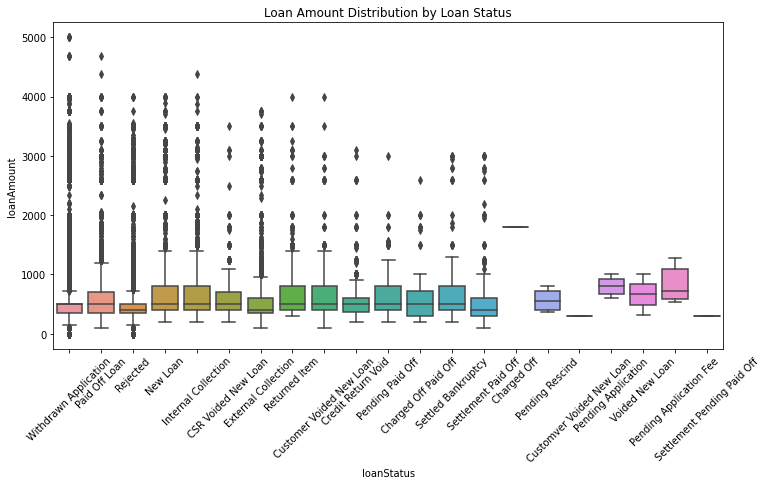

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='loanStatus', y='loanAmount', data=df)
plt.title('Loan Amount Distribution by Loan Status')
plt.xticks(rotation=45)
plt.show()

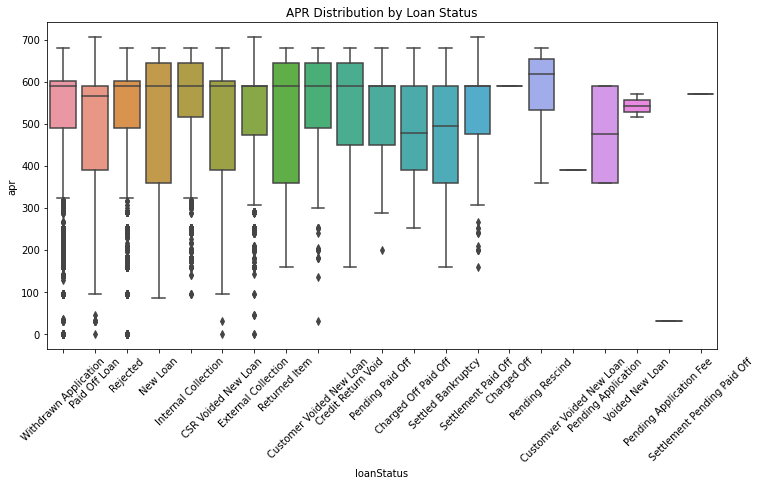

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='loanStatus', y='apr', data=df)
plt.title('APR Distribution by Loan Status')
plt.xticks(rotation=45)
plt.show()

In [14]:
print("Conclusions:")
print("- The dataset contains missing values in columns: \n", missing_values[missing_values > 0].index.tolist())
print("- There is a class imbalance in the target variable 'loanStatus'.")
print("- Several numerical features have skewed distributions.")
print("- Some features show a strong correlation with each other.")


Conclusions:
- The dataset contains missing values in columns: 
 ['loanId', 'payFrequency', 'apr', 'originatedDate', 'nPaidOff', 'loanStatus', 'loanAmount', 'state', 'fpStatus', 'clarityFraudId']
- There is a class imbalance in the target variable 'loanStatus'.
- Several numerical features have skewed distributions.
- Some features show a strong correlation with each other.


In [13]:
print("Next Steps:")
print("- Handle missing values during preprocessing.")
print("- Address class imbalance during model training (e.g., using SMOTE).")
print("- Consider feature scaling or transformation for skewed numerical features.")
print("- Explore feature interactions and engineer new features based on domain knowledge.")


Next Steps:
- Handle missing values during preprocessing.
- Address class imbalance during model training (e.g., using SMOTE).
- Consider feature scaling or transformation for skewed numerical features.
- Explore feature interactions and engineer new features based on domain knowledge.


## Check the [GitHub Repo](https://github.com/Sharvinm05/MoneyLion-Assessment) to check the whole pipeline and deployment code